In [2]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
from numba import jit, prange
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_loop_active
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc

tf.enable_eager_execution()

In [37]:
@jit(nopython=True)
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

@jit(nopython=True)
def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

@jit(nopython=True)
def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)
@jit(nopython=True)
def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)
@jit(nopython=True)
def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)
@jit(nopython=True)
def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
  
# n, m, and h steady-state values
@jit(nopython=True)
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))
@jit(nopython=True)
def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))
@jit(nopython=True)
def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))
  
@jit(nopython=True)
def Id(t):
    if 0.0 < t < 1.0:
        return 150.0
    elif 10.0 < t < 11.0:
        return 50.0
    return 0.0

@jit(nopython=True)
def compute_derivatives(y, t0, params):
    """Computes the derivatives of the HH-equations."""
    
    gK, gNa, gL, Cm, VK, VNa, Vl = params
    
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

@jit(parallel=True, cache=True)
def simulate_hh_batch(X, params, T, states):
    
    
    for i in prange(X.shape[0]):
        X[i] = odeint(compute_derivatives, states, T, args=(params[i], ))   
    

def simulate_hh(batch_size, t_min=0.0, t_max=50.0, t_obs=500, to_tensor=True):
    
    # Generate parameters
    theta = np.random.uniform(low=[10, 100, 0.05, 0.2, -24, 90, 5], 
                               high=[50, 160, .9, 2.0, -1, 150, 13],
                               size=(batch_size, 7))
    X = np.zeros((batch_size, t_obs, 4))
    states = np.array([0.0, n_inf(), m_inf(), h_inf()])
    # Time values
    T = np.linspace(t_min, t_max, t_obs)
    simulate_hh_batch(X, theta, T, states)

    if to_tensor:
        return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(theta, dtype=tf.float32)
    return X, theta

In [38]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=64, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.CuDNNLSTM(h_lstm_dim),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

In [48]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = ['gK', 'gNa', 'gL', 'Cm', 'VK', 'VNa', 'Vl']
theta_dim = 7
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .9
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [49]:
X_test, theta_test = simulate_hh(n_test)

In [50]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

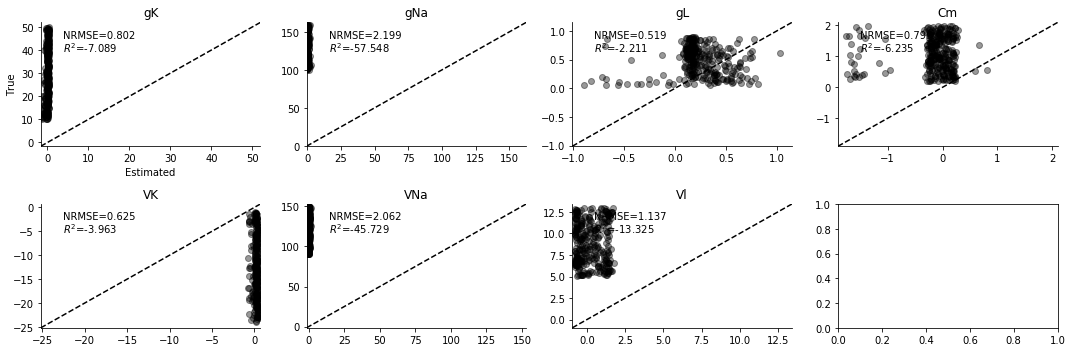

In [51]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(15, 5))

In [59]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_loop_active(model, optimizer, simulate_hh, iterations_per_epoch, 
                            batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                            global_step=global_step, ckpt_name='HH_{}'.format(ep))
        plot_losses(losses, figsize=(10, 4))
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 4))
        plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))

KeyboardInterrupt: 

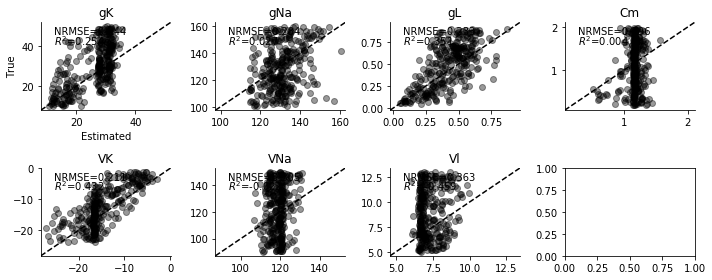

In [60]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 4))